# XLMR for crosslinual word in context sense disambiguation

## 1.1 XLMR
[XLM-RoBERTa](https://arxiv.org/abs/1911.02116) is a multilingual model trained on 100 different languages. It is based on RoBERTa: [A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692).

![](https://miro.medium.com/max/4800/1*2W7USnAt7tBVFb6IVqgzlA.png)

**XLMR vs BERT**
- Multilingual training dataset (100 languages)
- Multilingual tokenizer
- No "Next Sentence Prediction" loss
- Larger batch_size
- etc.

## 1.2 SemEval2021
**SemEval2021** task2: to distinguish whether the meanings of a target word in two provided contexts are the same or not.

- Click with a ***mouse*** on the shortcut

- A ***mouse*** ate the cheese

Also there are crosslingual sentece pairs.

## 1.3 All necessery imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#!pip install sentencepiece
#!pip install bitarray
#!pip install hydra-core
#!pip install sacrebleu
#!pip install editdistance



In [3]:
import json
import numpy as np
import torch
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from difflib import SequenceMatcher
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [4]:
# Загружаем XLM-R (базовая версия)
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = AutoModel.from_pretrained("xlm-roberta-base").eval().cuda()

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

## 1.4 Downloading and preparing the datasets for Semeval 2021 competition

In [5]:
!git clone https://github.com/SapienzaNLP/mcl-wic.git
!unzip mcl-wic/SemEval-2021_MCL-WiC_all-datasets.zip
!unzip mcl-wic/SemEval-2021_MCL-WiC_trial.zip
!unzip mcl-wic/SemEval-2021_MCL-WiC_test-gold-data.zip

Cloning into 'mcl-wic'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 226 (delta 65), reused 130 (delta 65), pack-reused 96 (from 1)
Receiving objects: 100% (226/226), 8.24 MiB | 18.50 MiB/s, done.
Resolving deltas: 100% (92/92), done.
Archive:  mcl-wic/SemEval-2021_MCL-WiC_all-datasets.zip
   creating: MCL-WiC/
   creating: MCL-WiC/training/
  inflating: MCL-WiC/training/training.en-en.data  
  inflating: MCL-WiC/training/training.en-en.gold  
  inflating: MCL-WiC/README.txt      
   creating: MCL-WiC/test/
   creating: MCL-WiC/test/crosslingual/
  inflating: MCL-WiC/test/crosslingual/test.en-ar.data  
  inflating: MCL-WiC/test/crosslingual/test.en-zh.data  
  inflating: MCL-WiC/test/crosslingual/test.en-ru.data  
  inflating: MCL-WiC/test/crosslingual/test.en-fr.data  
   creating: MCL-WiC/test/multilingual/
  inflating: MCL-WiC/test/multilingual/test.fr-fr.data  
  inflating: M

In [6]:
# English-English train (8k)
with open("./MCL-WiC/training/training.en-en.data") as f:
    train_x = json.load(f)
with open("./MCL-WiC/training/training.en-en.gold") as f:
    train_y = json.load(f)

In [7]:
# English-English dev (1k)
with open("./MCL-WiC/dev/multilingual/dev.en-en.data") as f:
    dev_enen_x = json.load(f)
with open("./MCL-WiC/dev/multilingual/dev.en-en.gold") as f:
    dev_enen_y = json.load(f)

In [8]:
# Russian-Russian test (1k)
with open("./MCL-WiC/test/multilingual/test.ru-ru.data") as f:
    test_ruru_x = json.load(f)
with open("test.ru-ru.gold") as f:
    test_ruru_y = json.load(f)

In [9]:
# English-Russian test (1k)
with open("./MCL-WiC/test/crosslingual/test.en-ru.data") as f:
    test_enru_x = json.load(f)
with open("test.en-ru.gold") as f:
    test_enru_y = json.load(f)

In [10]:
test_enru_x[0]

{'id': 'test.en-ru.0',
 'lemma': 'gently',
 'pos': 'ADV',
 'sentence1': "Unfortunately, that pressure seemed to have had some effect, and the Islamic Republic of Iran had been treated more gently in the 2008 Chairman's working paper.",
 'sentence2': 'На протяжении этого десятилетия цены на сырьевые товары в реальном выражении характеризовались в целом умеренной повышательной тенденцией.',
 'ranges1': '116-122',
 'ranges2': '103-112'}

In [11]:
test_enru_x[0]['sentence1'][116:122]

'gently'

In [12]:
test_enru_x[0]['sentence2'][103:1112]

'умеренной повышательной тенденцией.'

In [13]:
test_enru_y[0]

{'id': 'test.en-ru.0', 'tag': 'F'}

In [14]:
test_ruru_x[0]

{'id': 'test.ru-ru.0',
 'lemma': 'приглашение',
 'pos': 'NOUN',
 'sentence1': 'Автор утверждает, что не имеет средств для приглашения для этой цели адвоката и что в любом случае такая апелляция бесполезна.',
 'sentence2': 'Эта миссия была осуществлена по приглашению правительства Нигерии вследствие получения МОТ после 1994 года двух жалоб по поводу ареста ряда профсоюзных деятелей и принятия указов в нарушение принципов свободы ассоциации и права на организацию профсоюзов.',
 'start1': '43',
 'end1': '54',
 'start2': '32',
 'end2': '43'}

In [15]:
test_ruru_x[0]['sentence1'][43:54]

'приглашения'

In [16]:
test_ruru_x[0]['sentence2'][32:43]

'приглашению'

In [17]:
test_ruru_y[0]

{'id': 'test.ru-ru.0', 'tag': 'F'}

## 2.1 The pipeline of our solution:
1. Extract contextualized embeddings of target words (which meanings are needed to be disambiguated) with XLM-R.
2. Aggregate theese two embeddings into one.
3. Train a simple MLP on aggregated embeddings to clasify if the meanings of target words in the same meanings or not.
4. Test.

- For training we will use ONLY **English-English** sentence pairs from train 8k set.
- For validation we will use **English-English** sentence pairs from 1k val set.
- And finaly we will test the performance of our solution of the **Russian-Russian** and **English-Russian** crosslingual sentence pairs from test 1k set.


##2.2 Extracting the contextualized embeddings of the target words.

1. XLM-R produces embeddings (feature vectors) for every input token. As it uses [BPE](https://en.wikipedia.org/wiki/Byte_pair_encoding) encoding there is no one-to-one correspondens between tokens and words. That is why we need to find the positions of tokens in the tokenized sentence corresponding to the target word. For example, the sentence ***funniest*** => `[7477,93,525]`

2. To use information from all subwords of the target word we use the average all embeddings corresponding to the subwords.

3. It is a common practice to use not only the activations from the last layer of transformer (XLMR, BERT, etc.) but from the previous layer. We will use the sum of activations from the last two layers.

4. To compare meanings of the target word in to contexts our model needs to see simultaniously two contextualized embeddings. That is why we need to aggregate them into one merged embedding. It can be done in several ways:
    1. Concatenation
    2. Difference
    3. Summation
    4. Element-wise multiplication
    5. Absolute difference
    6. etc.




In [18]:
def similar(a, b):
    """
    Returns the similarity of two lists.
    """
    return SequenceMatcher(None, a, b).ratio()

def find_sub_list(sl,l):
    """
    Finds indices of sublist sl in a list l
    Example: find_sub_list([3,4],[0,1,2,3,4,5]) -> (3,4)
    """
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1

def get_token_ids_by_word(word,sentence):
    """
    This function that returns start and finish (positions) indeces of tokens
    corresponding to a required word in a sentence
    """
    sentence_tokens = list(xlmr.encode(sentence))
    sentence_words = sentence.split()

    sims = []
    for w in sentence_words:
        sims.append(similar(word,w))
    top_ind = np.argmax(sims)
    top_word = sentence_words[top_ind]
    top_word_tokens = list(xlmr.encode(top_word)[1:-1])

    inds = find_sub_list(top_word_tokens, sentence_tokens)
    return inds


In [19]:
def extract_embs(data_x,data_y):
    embs = []
    target = []
    with torch.no_grad():
        for el_x, el_y in tqdm(zip(data_x,data_y)):
            s1 = el_x["sentence1"]
            s2 = el_x["sentence2"]
            y = torch.FloatTensor([int(el_y["tag"]=="T")])
            pos1 = get_token_ids_by_word(el_x["lemma"],s1)
            pos2 = get_token_ids_by_word(el_x["lemma"],s2)
            tokens1 = xlmr.encode(s1)
            hidden = xlmr.extract_features(tokens1,return_all_hiddens=True)
            averaged = (hidden[-1] + hidden[-2]) / 2    #torch.cat((hidden[-1],hidden[-2]),dim=2)#
            last_layer_features1 = torch.mean(averaged[0,pos1[0]:pos1[1]+1],dim=0)

            tokens2 = xlmr.encode(s2)
            hidden = xlmr.extract_features(tokens2,return_all_hiddens=True)
            averaged = (hidden[-1] + hidden[-2]) / 2    #torch.cat((hidden[-1],hidden[-2]),dim=2)#
            last_layer_features2 = torch.mean(averaged[0,pos2[0]:pos2[1]+1],dim=0)

            # concat_emb = aggregate(last_layer_features1,last_layer_features2)
            embs.append([last_layer_features1.cuda(),last_layer_features2.cuda()])#concat_emb.cuda())
            target.append(y.cuda())

    return embs, target

In [20]:
from difflib import SequenceMatcher
import numpy as np

def similar(a, b):
    """Returns similarity ratio between two strings using SequenceMatcher"""
    return SequenceMatcher(None, a, b).ratio()

def find_sub_list(sl, l):
    """
    Finds the start and end indices of sublist `sl` inside list `l`.
    Example: find_sub_list([3, 4], [1, 2, 3, 4, 5]) -> (2, 3)
    Returns None if the sublist is not found.
    """
    sll = len(sl)
    for ind in (i for i, e in enumerate(l) if e == sl[0]):  # iterate over matches of the first token
        if l[ind:ind + sll] == sl:  # check if full sublist matches
            return ind, ind + sll - 1
    return None

def get_token_ids_by_word(word, sentence, tokenizer):
    """
    Returns the start and end token indices of the word (by lemma match)
    in the tokenized version of the sentence, using a HuggingFace tokenizer.
    """
    words = sentence.split()  # split sentence into words
    sims = [similar(word, w) for w in words]  # compute similarity between target lemma and each word
    top_ind = int(np.argmax(sims))  # find the most similar word index
    top_word = words[top_ind]  # select the word with highest similarity

    # Tokenize the full sentence and the best-matching word
    sentence_tokens = tokenizer.tokenize(sentence)  # tokenized sentence (no special tokens)
    word_tokens = tokenizer.tokenize(top_word)  # tokenized target word

    # Find the token span of the word in the sentence
    sublist_pos = find_sub_list(word_tokens, sentence_tokens)
    if sublist_pos is None:
        raise ValueError(f"Can't find tokens {word_tokens} in {sentence_tokens}")

    # Add +1 because HuggingFace model outputs include a special <s> token at position 0
    return sublist_pos[0] + 1, sublist_pos[1] + 1

In [21]:
def extract_embs(data_x, data_y):
    embs = []  # list to store pairs of embeddings (for sentence1 and sentence2)
    target = []  # list to store binary labels (0 or 1)

    with torch.no_grad():  # disable gradient calculation for faster inference
        for el_x, el_y in tqdm(zip(data_x, data_y)):  # loop over input and label pairs
            s1 = el_x["sentence1"]  # first version of the sentence
            s2 = el_x["sentence2"]  # second version of the sentence
            y = torch.FloatTensor([int(el_y["tag"] == "T")]).cuda()  # target label: 1 if tag is "T", else 0

            # Get token start and end indices of the target lemma in each sentence
            pos1 = get_token_ids_by_word(el_x["lemma"], s1, tokenizer)
            pos2 = get_token_ids_by_word(el_x["lemma"], s2, tokenizer)

            # --- Processing sentence 1 ---
            inputs1 = tokenizer(s1, return_tensors="pt", truncation=True).to("cuda")  # tokenize and move to GPU
            outputs1 = model(**inputs1, output_hidden_states=True)  # get model outputs with hidden states
            hidden_states1 = outputs1.hidden_states  # list of 13 tensors: embeddings + 12 transformer layers
            avg_hidden1 = (hidden_states1[-1] + hidden_states1[-2]) / 2  # average of last two layers
            token_embs1 = avg_hidden1[0, pos1[0]:pos1[1]+1]  # extract embeddings of lemma tokens
            last_layer_features1 = torch.mean(token_embs1, dim=0)  # average embeddings of the target word

            # --- Processing sentence 2 ---
            inputs2 = tokenizer(s2, return_tensors="pt", truncation=True).to("cuda")  # tokenize and move to GPU
            outputs2 = model(**inputs2, output_hidden_states=True)  # get hidden states
            hidden_states2 = outputs2.hidden_states
            avg_hidden2 = (hidden_states2[-1] + hidden_states2[-2]) / 2  # average of last two layers
            token_embs2 = avg_hidden2[0, pos2[0]:pos2[1]+1]  # extract lemma token embeddings
            last_layer_features2 = torch.mean(token_embs2, dim=0)  # average embeddings of the target word

            # Append embeddings and label to the result lists
            embs.append([last_layer_features1, last_layer_features2])
            target.append(y)

    return embs, target  # return list of embedding pairs and their corresponding labels

In [22]:
embs_train, target_train = extract_embs(train_x,train_y) # 8k en-en
embs_val, target_val = extract_embs(dev_enen_x,dev_enen_y) # 1k ru-ru
embs_test_ruru, target_test_ruru = extract_embs(test_ruru_x,test_ruru_y) # 1k ru-ru
embs_test_enru, target_test_enru = extract_embs(test_enru_x,test_enru_y) # 1k en-ru

8000it [02:31, 52.85it/s]
1000it [00:17, 56.53it/s]
1000it [00:18, 53.91it/s]
1000it [00:17, 56.01it/s]


## 2.3 Visualisation of XLMR contextualized word embeddings

In [23]:
X_ru = [embs[0].cpu().numpy() for embs, label in zip(embs_test_enru,target_test_enru) if label]
X_en = [embs[1].cpu().numpy() for embs, label in zip(embs_test_enru,target_test_enru) if label]

pca = PCA(n_components=2)
X_2D_en = pca.fit_transform(X_en)
X_2D_ru = pca.transform(X_ru)


In [24]:
texts_en = ["["+tmp["lemma"].upper() + "]\t" + tmp["sentence1"] for tmp in test_enru_x]
texts_ru = ["["+tmp["lemma"].upper() + "]\t" + tmp["sentence2"] for tmp in test_enru_x]


from plotly.subplots import make_subplots
import plotly.graph_objs as go

points_ru = go.Scatter(
    x = X_2D_ru[:, 0],
    y = X_2D_ru[:, 1],
    name = 'Russian',
    mode = 'markers',
    text = [t[:100] for t in texts_ru],
)

points_en = go.Scatter(
    x = X_2D_en[:, 0],
    y = X_2D_en[:, 1],
    name = 'English',
    mode = 'markers',
    text = [t[:100] for t in texts_en],
)

fig = make_subplots(rows=1, cols=1)
fig.add_trace(points_ru, row=1, col=1)
fig.add_trace(points_en, row=1, col=1)

fig.show(renderer="colab")

In [25]:
X_en1_true = [embs[0].cpu().numpy() for embs, label in zip(embs_train,target_train) if label]
X_en2_true = [embs[1].cpu().numpy() for embs, label in zip(embs_train,target_train) if label]

X_en1_false = [embs[0].cpu().numpy() for embs, label in zip(embs_train,target_train) if not label]
X_en2_false = [embs[1].cpu().numpy() for embs, label in zip(embs_train,target_train) if not label]

def cosine(v1,v2):
    """
    returns cosine similarity of two vectors
    """
    return v1 @ v2 / ((v1 @ v1) * (v2 @ v2)) ** 0.5
cosines = [cosine(v1,v2) for v1,v2 in zip(X_en1_true,X_en2_true)]

print("Mean cosine between words with same meaning:\n",np.mean(cosines))
cosines = [cosine(v1,v2) for v1,v2 in zip(X_en1_false,X_en2_false)]
print("Mean cosine between words with different meanings:\n",np.mean(cosines))

Mean cosine between words with same meaning:
 0.96872705
Mean cosine between words with different meanings:
 0.9528916


## 2.4 Aggregating the embeddings from two contexts

In [26]:
def aggregate(emb1,emb2, method="mul"):
    """
    input: two embeddings, method of aggregation (mul, sum, concat, diff, abs_diff)
    output: merged embeddings
    """
    if method == "mul":
        emb = emb1 * emb2
    if method == "sum":
        emb = emb1 + emb2
    if method == "concat":
        emb = torch.cat((emb1,emb2),1)
    if method == "diff":
        emb1 = emb1.div(torch.norm(emb1, p=2, dim=0).expand_as(emb1))
        emb2 = emb2.div(torch.norm(emb2, p=2, dim=0).expand_as(emb2))
        emb = emb1 - emb2
    if method == "abs_diff":
        emb1 = emb1.div(torch.norm(emb1, p=2, dim=0).expand_as(emb1))
        emb2 = emb2.div(torch.norm(emb2, p=2, dim=0).expand_as(emb2))
        emb = torch.abs(emb1 - emb2)
    return emb

In [27]:
embs_train_aggr = []
embs_val_aggr = []
embs_test_aggr_enru = []
embs_test_aggr_ruru = []

for emb1, emb2 in embs_train:
    embs_train_aggr.append(aggregate(emb1,emb2))

for emb1, emb2 in embs_val:
    embs_val_aggr.append(aggregate(emb1,emb2))

for emb1, emb2 in embs_test_enru:
    embs_test_aggr_enru.append(aggregate(emb1,emb2))

for emb1, emb2 in embs_test_ruru:
    embs_test_aggr_ruru.append(aggregate(emb1,emb2))

In [28]:
print(embs_train_aggr[0].shape)
print(len(embs_train_aggr))

torch.Size([768])
8000


In [29]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,embs_train_aggr,target_train):
        super(Dataset,self).__init__()
        self.x = embs_train_aggr
        self.y = target_train
    def __len__(self):
        return len(self.x)
    def __getitem__(self,i):
        return self.x[i], self.y[i]

dataset = Dataset(embs_train_aggr,target_train)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=128,shuffle=True)

## 2.5 Training

In [30]:
mlp = nn.Sequential(
    nn.Linear(768,512),
    nn.Dropout(0.3),
    nn.GELU(),
    nn.Linear(512,256),
    nn.Dropout(0.3),
    nn.GELU(),
    nn.Linear(256,1),
    nn.Sigmoid()).cuda()

opt = torch.optim.AdamW(mlp.parameters(),lr=1e-4)

In [31]:
losses = []
roc_auc = []

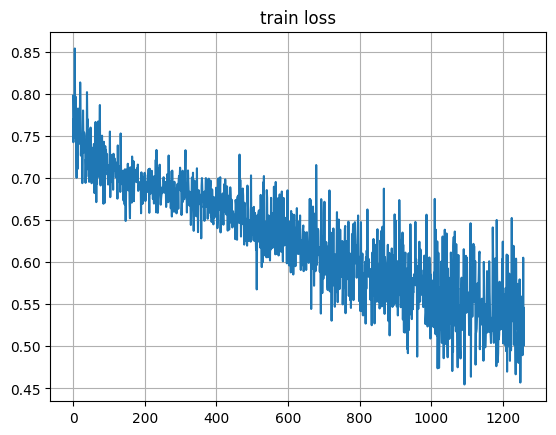

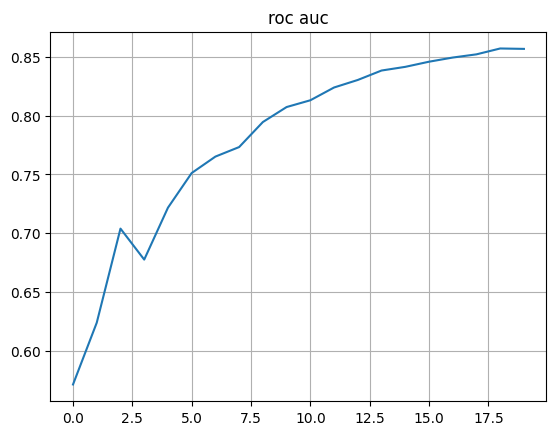

auc:  0.8569040000000001
epoch:  19


In [32]:
# TRAINING LOOP
for epoch in range(20):
    for emb, y in dataloader:
        mlp.train()

        predict = mlp(emb)
        loss = nn.BCELoss()(predict,y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        losses.append(loss)

    with torch.no_grad():
        correct = 0
        preds = []
        targets = []
        for emb, y in zip(embs_val_aggr,target_val):
            mlp.eval()
            predict = mlp(emb[None,...])
            preds.append(float(predict))
            targets.append(int(y.item()))
        auc = roc_auc_score(targets,preds)
        roc_auc.append(auc)

    clear_output(wait=True)
    plt.title("train loss")
    plt.plot([i.cpu().detach().numpy() for i in losses])
    plt.grid()
    plt.show()
    plt.title("roc auc")
    plt.plot(roc_auc)
    plt.grid()
    plt.show()
    print("auc: ",roc_auc[-1])
    print("epoch: ",epoch)

## 3. Tests

#### 3.1 Test on Russian-Russian sentence pairs

In [33]:
#ruru
with torch.no_grad():
    correct = 0
    preds = []
    targets = []
    for emb, y in zip(embs_test_aggr_ruru,target_test_ruru):
        mlp.eval()
        predict = mlp(emb)
        preds.append(float(predict.item()))
        targets.append(int(y.item()))
    auc = roc_auc_score(targets,preds)
print("auc",auc)


auc 0.783004


#### 3.2 Test on English-Russian sentence pairs (crosslingual)

In [34]:
#enru
with torch.no_grad():
    correct = 0
    preds = []
    targets = []
    for emb, y in zip(embs_test_aggr_enru,target_test_enru):
        mlp.eval()
        predict = mlp(emb)
        preds.append(float(predict.item()))
        targets.append(int(y.item()))
    auc = roc_auc_score(targets,preds)
print("auc",auc)


auc 0.6432880000000001
